In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools

from dynamics.duffing import dynamics_duff


## Simulation Parameters

In [2]:
# Base Parameters
dt = 0.01 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 200 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories

## Single System
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

## System Parameters

In [3]:
# Oscillator parameters
dyn_pars = {}


## Single System

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5

dyn_pars['del_a'] = 0
dyn_pars['del_b'] = 0
dyn_pars['del_c'] = 0
dyn_pars['del_d'] = 0

dyn_pars['delay'] =  False
dyn_pars['delay_time'] = 5
dyn_pars['cont_unc_type'] = 'constant'

## Data Generation

### Trajectory Generation

In [4]:
# Trajectories
X_full, _, U_full = dynamics_duff(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X_full.shape, U_full.shape)

(250, 1001, 2) (250, 1000, 1)


### Dataset Visualization

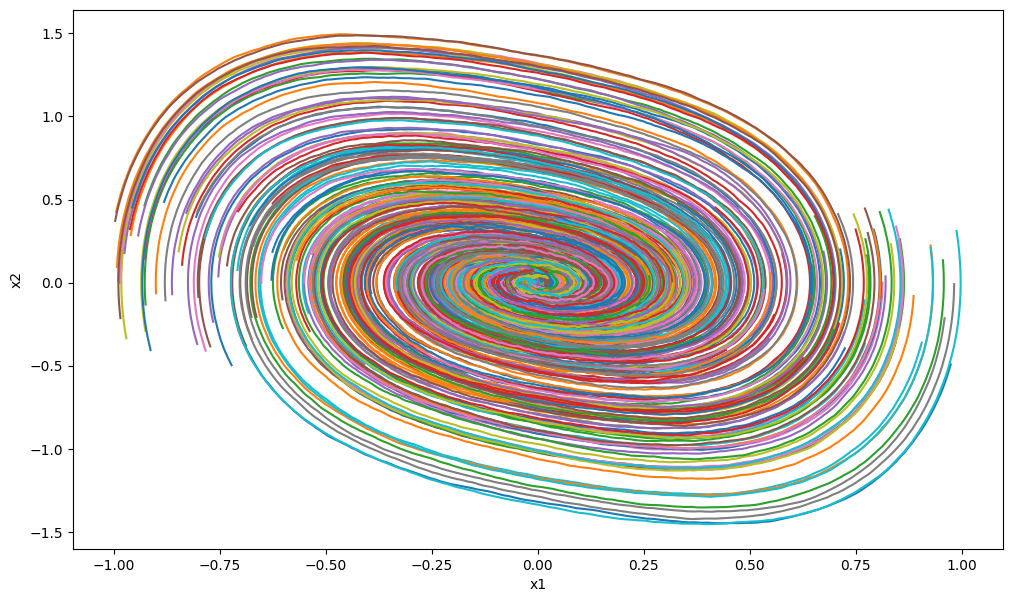

In [5]:
# plot dataset
fig, axs = plt.subplots(1,1,figsize=(12,7))

axs.set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs.plot(X_full[i,:,0], X_full[i,:,1])

In [6]:
## Reshape the matricies
X = np.zeros((num_states, num_snaps*num_traj))
X_dash = np.zeros((num_states, num_snaps*num_traj)) # one step ahead
U_flat = np.zeros((num_inputs,num_snaps*num_traj))
for i in range(num_traj):
    # Reshape the matricies and develope the snapshot matries
    X[:, i*num_snaps:(i+1)*num_snaps] = X_full[i,:-1,:].T
    X_dash[:, i*num_snaps:(i+1)*num_snaps] = X_full[i,1:,:].T
    U_flat[:, i*num_snaps:(i+1)*num_snaps] = U_full[i,:,:].T

In [7]:
print("Shape for X_full = ", X_full.shape)
print("Shape for X = ", X.shape)
print("Shape for X_dash = ", X_dash.shape)
print("Shape for U_full = ", U_full.shape)
print("Shape for U_flat = ", U_flat.shape)

Shape for X_full =  (250, 1001, 2)
Shape for X =  (2, 250000)
Shape for X_dash =  (2, 250000)
Shape for U_full =  (250, 1000, 1)
Shape for U_flat =  (1, 250000)


***Koopman Implementation***

***Polynomial basis***

In [8]:
def indicies(max_power,num_states, state_interaction):
    arr = np.tile(np.arange(max_power+1),num_states)
    base_list = list(itertools.combinations(arr, num_states))
    full_arr = np.unique(np.array(base_list),axis = 0)
    dim = full_arr.shape[0]
    del_index = []
    for i in range(full_arr.shape[0]):
        if np.sum(full_arr[i,:])==1:
            del_index.append(i)
        if state_interaction == False:
            if np.sum(full_arr[i,:]) > np.max(full_arr[i,:]):
                del_index.append(i)
    red_arr = np.delete(full_arr, del_index, axis = 0) # remove colums with linear and contant polynomials
    return np.vstack((np.identity(num_states),red_arr)) # add the linear components to make change to base states easy



In [9]:
print(indicies(2,6,state_interaction=True))

print(indicies(1,6,state_interaction=True).shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [2. 2. 2. 2. 2. 0.]
 [2. 2. 2. 2. 2. 1.]
 [2. 2. 2. 2. 2. 2.]]
(64, 6)


In [10]:
def lift_poly(max_power, data, inputs,state_interaction,model_type):
    num_states = data.shape[0]
    index = indicies(max_power,num_states,state_interaction)
    dim = index.shape[0] # lifted state dimension
    length = data.shape[1]
    #print(dim,length)
    num_inputs = inputs.shape[0]
    #print(num_inputs) 
    
    if model_type == 'linear':
        data_lifted = np.ones((dim,length))   
    elif model_type == 'bilinear':    
        data_lifted = np.ones(((num_inputs+1)*dim,length))
    else:
        print("invalid model type")
        return None
    
    for i in range(length):
        for j in range(dim):
            for k in range(num_states):
                data_lifted[j,i] = data_lifted[j,i]*(data[k,i]**index[j,k])
            if model_type == "bilinear":
                for l in range(num_inputs):
                    data_lifted[j+(l+1)*dim,i] = data_lifted[j,i]*inputs[l,i]
    return data_lifted

In [11]:
def generate_centres(num_centres, data):
    # centres = np.vstack((0.1*(2*np.random.rand(int(num_states/2),num_centres) - 1),
    #                     np.pi*(2*np.random.rand(int(num_states/2),num_centres) - 1)))
    num_states = data.shape[0]
    length = data.shape[1]
    idx = np.random.choice(np.arange(length),num_centres)
    centres = np.zeros((num_states,num_centres))
    j = 0
    for i in idx:
        centres[:,j] = data[:,i]
        j= j+1
    return centres

In [12]:
def lift_rbf(centre,data,inputs, basis, model_type):
    

    
    def basis_function(basis,epsilon,r):
        if basis == 'gaussian':
            out = np.exp(-(epsilon*r)**2)
        elif basis == 'multiquadratic':
            out = np.sqrt(1+(epsilon*r)**2)
        elif basis == 'inverse_quadratic':
            out = 1/np.sqrt(1+(epsilon*r)**2)
        elif basis == 'thin_plate':
            if r == 0:
                out = 0
            else:
                out = np.log(r)*r**2
        elif basis == 'quadratic':
            out = r**2
        else:
            print('Invalid Basis Function')
            return None
        
        return out 
        
        
    num_basis = centre.shape[1] 
    num_states = data.shape[0]
    length = data.shape[1]
    num_inputs = inputs.shape[0]
    
    
    if model_type == "linear":
        data_lifted = np.zeros((num_basis,length))
    elif model_type == "bilinear":    
        data_lifted = np.zeros(((num_inputs+1)*num_basis,length))
    else:
        print("invalid model type")
        return None
    
    for i in range(length):
        for j in range(num_basis):
            distance = np.linalg.norm(data[:,i] - centre[:,j])
            data_lifted[j,i] = basis_function(basis,0.17,distance)
            if model_type == "bilinear":
                for l in range(num_inputs):
                    data_lifted[j+(l+1)*num_basis,i] = data_lifted[j,i]*inputs[l,i]    
            
    return data_lifted

In [13]:
## lifting parameters

## polynomial basis

poly_deg = 3
state_interaction = False

## rbf parameters
num_basis = 17
rbf_fun = 'thin_plate'
centre = generate_centres(num_basis,X)
##
basis = 'polynomial'



In [14]:

if basis == 'polynomial':
    # bilinear lifted states
    X_lifted_bil = lift_poly(poly_deg,X,U_flat,state_interaction,'bilinear')
    print("done ----- 1/4")
    X_dash_lifted_bil = lift_poly(poly_deg,X_dash,U_flat,state_interaction,'bilinear')
    print("done ----- 2/4")
    # linear lifted states
    X_lifted_lin = lift_poly(poly_deg,X,U_flat,state_interaction,'linear')
    print("done ----- 3/4")
    X_dash_lifted_lin = lift_poly(poly_deg,X_dash,U_flat,state_interaction,'linear')
    print("done ----- 4/4")    
elif basis == 'rbf':
    # bilinear lifted states
    X_lifted_bil = lift_rbf(centre,X,U_flat, rbf_fun,'bilinear')
    print("done ----- 1/4")
    X_dash_lifted_bil = lift_rbf(centre,X_dash,U_flat, rbf_fun,'bilinear')
    print("done ----- 2/4")
    # linear lifted states
    X_lifted_lin = lift_rbf(centre,X,U_flat, rbf_fun,'linear')
    print("done ----- 3/4")
    X_dash_lifted_lin = lift_rbf(centre,X_dash,U_flat, rbf_fun,'linear')
    print("done ----- 4/4")


done ----- 1/4
done ----- 2/4
done ----- 3/4
done ----- 4/4


In [15]:
print(X_lifted_bil.shape)
print(X_lifted_lin.shape)

(14, 250000)
(7, 250000)


In [16]:
np.sum(np.isnan(X_lifted_lin)),np.max(X_lifted_lin),np.min(X_lifted_lin)

(0, 3.340357016097286, -3.07607717465463)

In [17]:
print(X_lifted_bil.shape[0])
print(U_flat.shape[0])
print(int(X_lifted_bil.shape[0]/(U_flat.shape[0]+1)))

14
1
7


***DMDc***

In [19]:
#DMDc for bilinear model
def DMDc_bil(X_lifted, X_dash_lifted, U_flat,num_base_states):
    n_total = X_lifted.shape[0]
    n_inputs = U_flat.shape[0]
    n_obs = int(n_total/(n_inputs+1))
    # combined control and lifted state matricies gamma
    gamma = np.transpose(np.vstack((X_lifted,U_flat)))
    gamma_dash = np.transpose(np.vstack((X_dash_lifted,U_flat)))
    K = np.matmul(np.linalg.pinv(gamma), gamma_dash)
    # A,H,B and C
    K_t = np.transpose(K) 
    A = K_t[:n_obs, :n_obs]
    H = K_t[:n_obs,n_obs:(num_inputs+1)*n_obs]
    B = K_t[:n_obs,-(n_inputs):]
    C = np.hstack((np.identity(num_base_states),np.zeros((num_base_states, n_obs-num_base_states))))
    return A,H,B,C



In [20]:
#DMDc for linear model
def DMDc_lin(X_lifted, X_dash_lifted, U_flat,num_base_states):
    n_total = X_lifted.shape[0]
    n_inputs = U_flat.shape[0]
    n_obs = int(n_total)
    # combined control and lifted state matricies gamma
    gamma = np.vstack((X_lifted,U_flat)).transpose()
    gamma_dash = np.vstack((X_dash_lifted,U_flat)).transpose()
    K = np.matmul(np.linalg.pinv(gamma), gamma_dash)
    # A,H,B and C
    K_t = K.transpose() 
    A = K_t[:n_obs, :n_obs]
    B = K_t[:n_obs,-(n_inputs):]
    C = np.hstack((np.identity(num_base_states),np.zeros((num_base_states, n_obs-num_base_states))))
    return A,B,C

In [21]:
#A_bil = np.genfromtxt('A_bil.csv', delimiter=',',)
#B_bil = np.genfromtxt('B_bil.csv', delimiter=',',)
#C_bil = np.genfromtxt('C.csv', delimiter=',',)
#H = np.genfromtxt('H_bil.csv', delimiter=',',)


In [22]:
# DMDc
A_bil,H,B_bil,C_bil = DMDc_bil(X_lifted_bil,X_dash_lifted_bil,U_flat,num_states)
A_lin,B_lin,C_lin = DMDc_lin(X_lifted_lin,X_dash_lifted_lin,U_flat,num_states)

In [23]:
print(A_bil.shape,B_bil.shape, C_bil.shape, H.shape)
print(A_lin.shape,B_lin.shape, C_lin.shape)

(7, 7) (7, 1) (2, 7) (7, 7)
(7, 7) (7, 1) (2, 7)


***Validation***

In [25]:
num_snaps_val = 500 # the time values
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)

In [26]:
# get validation data
x_val_raw, _, u_val_raw = dynamics_duff(dt, 1, num_snaps_val, num_states, num_inputs, dyn_pars)

In [27]:
x_val = x_val_raw[0,:,:].T
u_val = u_val_raw[0,:,:].T

In [28]:
x_val.shape,u_val.shape

((2, 501), (1, 500))

In [29]:
u_val[:,0].reshape(-1,1)

array([[-0.45221964]])

In [30]:
# lift states
if basis == 'polynomial':
    Z = lift_poly(poly_deg, x_val[:,0].reshape(-1,1),u_val[:,0].reshape(-1,1),state_interaction,'bilinear') # lifting of intial state
elif basis == 'rbf':
    Z = lift_rbf(centre, x_val[:,0].reshape(-1,1),u_val[:,0].reshape(-1,1),rbf_fun,'bilinear') # lifting of intial state
#Z= np.genfromtxt('Z_first_mat.csv', delimiter=',',).reshape(-1,1)
#np.savetxt('Z_first_data.csv', Z, delimiter=',')

In [31]:
Z.shape

(14, 1)

In [32]:
# initialize the matricies
n_obs = int(Z.shape[0]/(num_inputs+1))
z_lin = np.empty((n_obs,num_snaps_val+1))
z_act = np.empty((n_obs,num_snaps_val+1))
z_bil = np.empty((n_obs,num_snaps_val+1))
x_est_lin = np.zeros((num_states,num_snaps_val+1))
x_est_bil = np.zeros((num_states,num_snaps_val+1))

In [33]:
z_lin[:,0] = Z[:n_obs,0].reshape(-1,)
z_bil[:,0] = Z[:n_obs,0].reshape(-1,)
x_est_lin[:,0] = x_val[:,0].reshape(-1,)
x_est_bil[:,0] = x_val[:,0].reshape(-1,)

In [34]:
if basis == 'polynomial':
    z_act = lift_poly(poly_deg, x_val[:,0].reshape(-1,1),u_val[:,0].reshape(-1,1),state_interaction,'linear') # lifting of intial state
elif basis == 'rbf':
    z_act = lift_rbf(centre, x_val,u_val[:,0],rbf_fun,'linear') # lifting of intial state
#Z= np.genfromtxt('Z_first_mat.csv', delimiter=',',).reshape(-1,1)
#np.savetxt('Z_first_data.csv', Z, delimiter=',')

In [35]:
#intial_values of x

In [36]:
# Time evolution
for i in range(num_snaps_val):
  #bilinear
    z_bil[:,i+1] = np.matmul(A_bil,z_bil[:,i])+np.matmul(B_bil,u_val[:,i])+np.matmul(H,np.kron(u_val[:,i],z_bil[:,i]))
    x_est_bil[:,i+1] = np.matmul(C_bil,z_bil[:,i+1])
    #linear
    z_lin[:,i+1] = np.matmul(A_lin,z_lin[:,i])+np.matmul(B_lin,u_val[:,i])
    x_est_lin[:,i+1] = np.matmul(C_lin,z_lin[:,i+1])
    

## Joint Space Errors

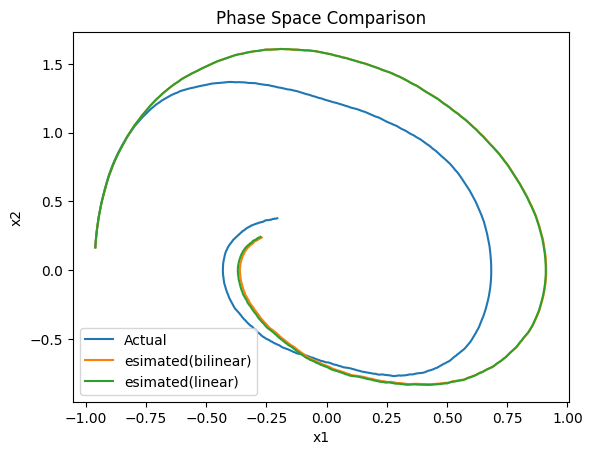

In [42]:
plt.figure()
plt.plot(x_val[0,:], x_val[1,:],label ='Actual')
plt.plot(x_est_bil[0,:],x_est_bil[1,:],label = 'esimated(bilinear)')
plt.plot(x_est_lin[0,:],x_est_lin[1,:],label = 'esimated(linear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space Comparison')
plt.legend()


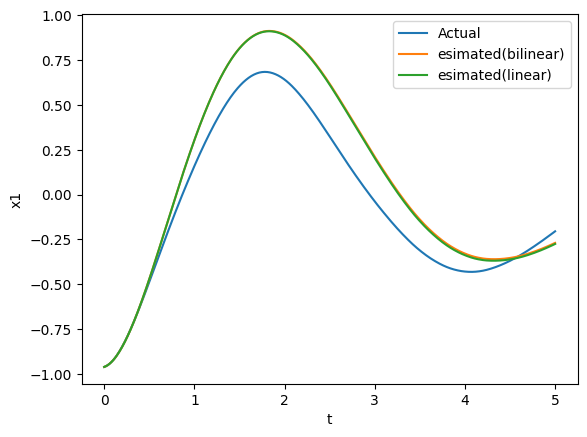

In [43]:
plt.figure()
plt.plot(T,x_val[0,:],label ='Actual')
plt.plot(T,x_est_bil[0,:],label = 'esimated(bilinear)')
plt.plot(T,x_est_lin[0,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.legend()


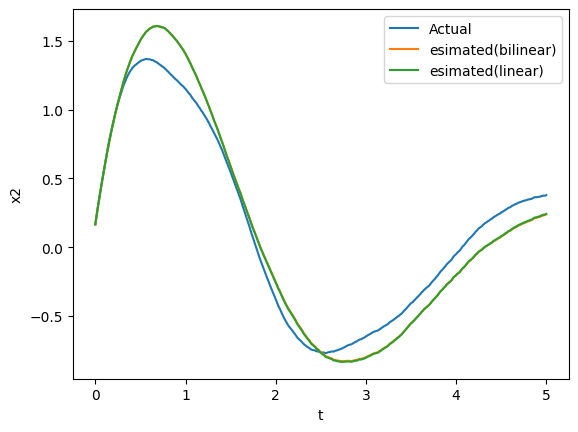

In [44]:
plt.figure()
plt.plot(T,x_val[1,:],label ='Actual')
plt.plot(T,x_est_bil[1,:],label = 'esimated(bilinear)')
plt.plot(T,x_est_lin[1,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.legend()

In [46]:
error_mse_bil = np.sqrt(np.square(x_est_bil[0:2,:]-x_val[0:2,:]).mean(axis=0))
error_mse_lin = np.sqrt(np.square(x_est_lin[0:2,:]-x_val[0:2,:]).mean(axis=0))

Text(0.5, 1.0, 'error evolution')

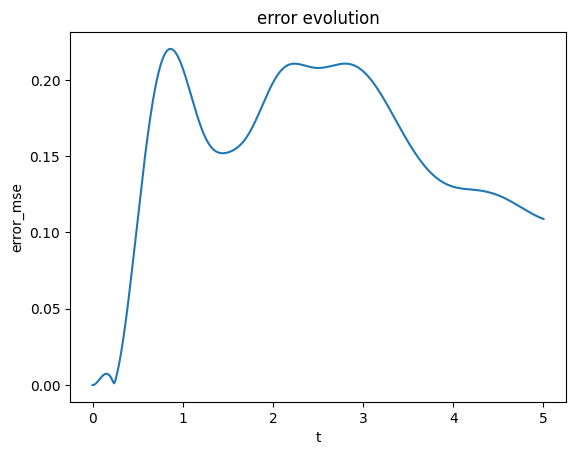

In [47]:
plt.figure()
plt.plot(T,error_mse_bil)
plt.xlabel('t')
plt.ylabel('error_mse')
plt.title('error evolution')

Text(0.5, 1.0, 'error evolution')

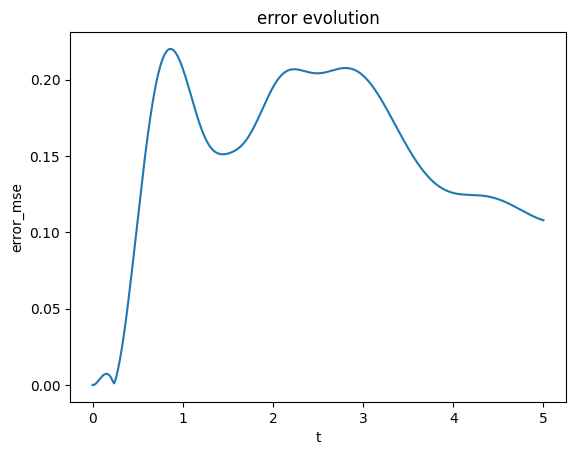

In [51]:
plt.figure()
plt.plot(T,error_mse_lin)
plt.xlabel('t')
plt.ylabel('error_mse')
plt.title('error evolution')

In [53]:
print('Bilinear Model Error : ',np.mean(error_mse_bil))
print('Linear Model Error : ',np.mean(error_mse_lin))

Bilinear Model Error :  0.1540942116464002
Linear Model Error :  0.15180428887186423


## Controllability

In [58]:
import control as ct

C = ct.ctrb(A_lin, B_lin)
np.linalg.matrix_rank(C)

6

In [57]:
C = ct.ctrb(A_bil, B_bil)
np.linalg.matrix_rank(C)

6